In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
n_estimators = 500
random_state = 42

# Train and Apply micoRNA Discovery model
This notebook demonstrates how to train and apply the microRNA discovery model based on species specifc training data from SMIRP

In [2]:
positive_data_file = '../../data/training_sets/Caenorhabditis_elegans_SMRP_positive_training_set.csv'
negative_data_file = '../../data/training_sets/Caenorhabditis_elegans_SMRP_negative_training_set.csv'
ouput_folder_location = '../../data/trained_miRNA_discovery_models/SCN'
candidate_set_file = '../../data/candidate_set_generation/scn_genome_chromosome_8.rep.fasta.hmp20.csv'

In [10]:
train_data = pd.concat([pd.read_csv(positive_data_file, header=None),pd.read_csv(negative_data_file, header=None)],axis=0).reset_index(drop=True)
train_data.iloc[:,-1] = train_data.iloc[:,-1].map(dict(miRNA=1.0,pseudo=0.0))

X_train = train_data.drop(columns=[0,1,22])
Y_train = train_data.iloc[:,-1]

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_scale = scaler.transform(X_train)

experiment_RF = RandomForestClassifier(n_estimators = n_estimators)

#Initalize SMOTE algorithm
smoter = SMOTE(sampling_strategy='minority',random_state=42)

#Upsample training data
X_upsample, y_upsample = smoter.fit_resample(X_scale,Y_train)

#Fit the model on the upsampled training data
experiment_RF = experiment_RF.fit(X_upsample, y_upsample)

pickle.dump(scaler, open(f"{ouput_folder_location}/miRNA_discovery_scaler.pkl", "wb" ))
pickle.dump(experiment_RF, open(f"{ouput_folder_location}/miRNA_discovery_random_forest_model.pkl", "wb" ))

Threshold 0.8: (0.9542994588093806,1.0) Accuracy: 0.9766816143497757
Threshold 0.9: (0.8701142513529766,1.0) Accuracy: 0.9342301943198804
AUC: 1.0
Precision at Recall 50% []


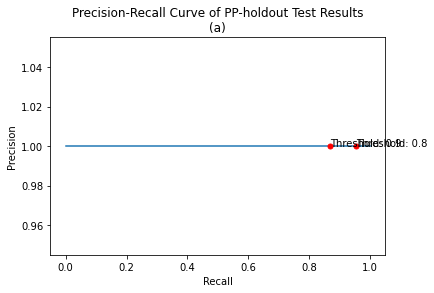

/home/victoriaajila-admin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/victoriaajila-admin/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


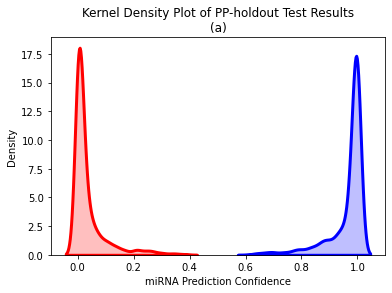

In [11]:
results = pd.concat([train_data.iloc[:,0], pd.Series(Y_train),pd.Series(experiment_RF.predict_proba(X_scale)[:,1])], axis=1)

precision, recall, threshold = precision_recall_curve(results.iloc[:,1],results.iloc[:,2])
disp1 = PrecisionRecallDisplay(precision=precision, recall=recall)
disp1.plot()
loc_08 = np.where(np.abs(threshold-0.8)<0.00201)[0][0]
loc_09 = np.where(np.abs(threshold-0.9)<0.003)[0][0]
disp1.ax_.annotate("Threshold: 0.8",(recall[loc_08],precision[loc_08]))
disp1.ax_.plot(recall[loc_08],precision[loc_08],color='red',marker='o', markersize=5)
disp1.ax_.annotate("Threshold: 0.9",(recall[loc_09],precision[loc_09]))
disp1.ax_.plot(recall[loc_09],precision[loc_09],color='red',marker='o', markersize=5)
y_pred_08 = np.where(results.iloc[:,2] >=0.8,1,0)
y_pred_09 = np.where(results.iloc[:,2] >=0.9,1,0)
print(f'Threshold 0.8: ({recall[loc_08]},{precision[loc_08]}) Accuracy: {accuracy_score(results.iloc[:,1],y_pred_08)}')
print(f'Threshold 0.9: ({recall[loc_09]},{precision[loc_09]}) Accuracy: {accuracy_score(results.iloc[:,1],y_pred_09)}')
print(f'AUC: {auc(recall, precision)}')
print(f'Precision at Recall 50% {precision[np.where(np.abs(recall-0.5)<0.002)[0]]}')
plt.title("Precision-Recall Curve of PP-holdout Test Results\n(a)")
plt.savefig(f"{ouput_folder_location}/miRNA_discovery_training_set_PR_curve.png")
plt.show()


positive_data = results.iloc[np.where(results.iloc[:,1] == 1)[0], 2]
positive_data.name = "miRNA Prediction Confidence"
negative_data = results.iloc[np.where(results.iloc[:,1] == 0)[0], 2]
negative_data.name = "miRNA Prediction Confidence"

sns.distplot(positive_data, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, label="Positive Test Data", color="blue", norm_hist=True)
sns.distplot(negative_data, hist=False, kde=True, kde_kws={'shade': True, 'linewidth': 3}, label="Negative Test Data", color="red", norm_hist=True)
plt.ylabel("Density")
plt.title("Kernel Density Plot of PP-holdout Test Results\n(a)")
plt.savefig(f"{ouput_folder_location}/miRNA_discovery_training_set_density_plot.png")
plt.show()

In [13]:
unknown = pd.read_csv(candidate_set_file, header=None)
X_unknown = unknown.drop(columns=[0])

y_prediction_RF = experiment_RF.predict_proba(scaler.transform(X_unknown))[:,1]

results_RF_3 = pd.DataFrame(unknown[0])
results_RF_3[1] = y_prediction_RF
results_RF_3.to_csv(f"{ouput_folder_location}/candidate_set_predictions.csv",index=False,header=False)